In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk.corpus
import re, string
import progressbar
import numpy as np
import matplotlib.gridspec as gridspec 

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, recall_score

In [2]:
# Examining the data
train = pd.read_csv('train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
test = pd.read_csv('test.csv')
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [4]:
test_y = pd.read_csv('test_labels.csv')
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [5]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
lens = train['comment_text'].str.len()
lens.mean(), lens.max(), lens.min(), lens.std()

(394.0732213246768, 5000, 6, 590.7202819048919)

<AxesSubplot:>

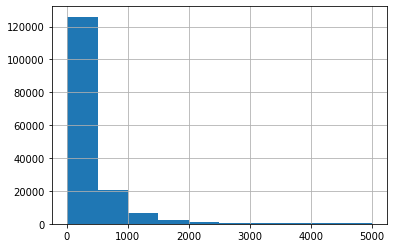

In [7]:
lens.hist()  

In [8]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='Feature'>

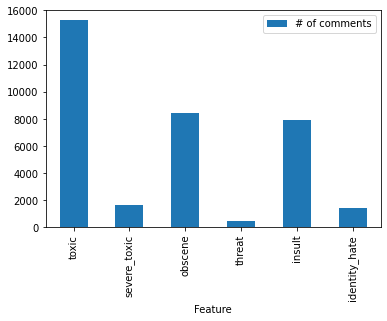

In [9]:
feature = train.drop(['id', 'comment_text'], axis=1)
count = []
categories = list(feature.columns.values)
for i in categories:
    count.append((i, feature[i].sum()))
# count
df_feature = pd.DataFrame(count, columns=['Feature', '# of comments'])
df_feature.plot(x='Feature', y='# of comments', kind='bar')

<AxesSubplot:>

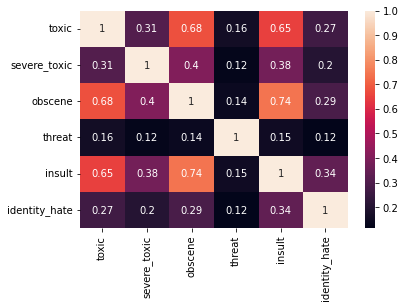

In [10]:
sns.heatmap(feature.corr(), annot = True)

In [11]:
# cleaning the data
nltk.download('stopwords')
nltk.download('wordnet') 
nltk.download('omw-1.4')
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    text = nopunct.split(' ')
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(text)) # remove unicode characters
    text = re.sub(r'[^a-zA-Z\s]+', '', text)
    text = ' '.join([word for word in text.split(' ') if word not in stop]) # remove stop words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')]) # lemmatization
    text = re.sub(' +', ' ', text) # remove extra spaces
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\conni\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\conni\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\conni\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [12]:
tqdm.pandas()
train_clean = train
train_clean['clean_text'] = train['comment_text'].progress_apply(clean_text)

100%|██████████| 159571/159571 [00:46<00:00, 3415.98it/s]


In [13]:
train_clean.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seemingly stuck th...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really trying edit war guy constantly ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggestion improvement wondered sec...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page


In [23]:
train_clean.to_csv('clean.csv')

In [14]:
test_labels = ["toxic", "severe_toxic", "obscene",
               "threat", "insult", "identity_hate"]

In [15]:
# using ngrams suggested by this paper
# https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, 
                             sublinear_tf=True, smooth_idf=True,
                             strip_accents='unicode', stop_words='english',
                             analyzer='word')
X_train = vectorizer.fit_transform(train_clean['clean_text'])
X_test = vectorizer.transform(test['comment_text'])

In [16]:
# features from tf-idf vectorizer 
vectorizer.get_feature_names()[0:20]

c:\users\conni\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aa',
 'aa aa',
 'aaa',
 'aaaa',
 'aaand',
 'aab',
 'aac',
 'aachen',
 'aad',
 'aadministrators',
 'aadministrators noticeboard',
 'aah',
 'aaliyah',
 'aamir',
 'aan',
 'aand',
 'aang',
 'aap',
 'aap demand',
 'aap website']

In [17]:
train_tags=train.iloc[:,2:]

In [18]:
# https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
#     ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
# ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
#     ''' Return the top n features that on average are most important amongst documents in rows
#         indentified by indices in grp_ids. '''

    D = Xtr[grp_ids].toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)


def top_feats_by_class(Xtr, features, min_tfidf=0.1, top_n=20):
#     ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
#         calculated across documents with the same class label. '''
    dfs = []
    cols=train_tags.columns
    for col in cols:
        ids = train_tags.index[train_tags[col]==1]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.col = col
        dfs.append(feats_df)
    return dfs

In [19]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)
corpus=merge.comment_text
clean_corpus=corpus.apply(lambda x :clean_text(x))
features = vectorizer.get_feature_names()
train_unigrams = vectorizer.transform(clean_corpus.iloc[:train.shape[0]])


In [20]:
tfidf_top_n_per_lass=top_feats_by_class(train_unigrams,features)
tfidf_top_n_per_lass

c:\users\conni\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\conni\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


[    feature     tfidf
 0      fuck  0.035904
 1   fucking  0.019543
 2      shit  0.014247
 3      suck  0.013835
 4     bitch  0.012143
 5    stupid  0.010257
 6   asshole  0.010018
 7     idiot  0.009620
 8      dick  0.009020
 9       gay  0.009007
 10   faggot  0.008766
 11     cunt  0.008030
 12     stop  0.007722
 13     hell  0.006944
 14     life  0.005999
 15     hate  0.005854
 16      hey  0.005629
 17     cock  0.005338
 18     like  0.005245
 19     shut  0.004902,
          feature     tfidf
 0           fuck  0.115412
 1        fucking  0.053442
 2          bitch  0.038632
 3           suck  0.032827
 4           shit  0.029335
 5           dick  0.023851
 6        asshole  0.023848
 7      fuck fuck  0.021750
 8           cunt  0.020659
 9         faggot  0.019046
 10          cock  0.015459
 11           gay  0.012055
 12        fucker  0.011770
 13     suck dick  0.011630
 14           die  0.011599
 15        nigger  0.011525
 16         piece  0.010954
 17    piece

C:\Users\conni\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\conni\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\conni\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

Text(0, 0.5, 'TF-IDF score')

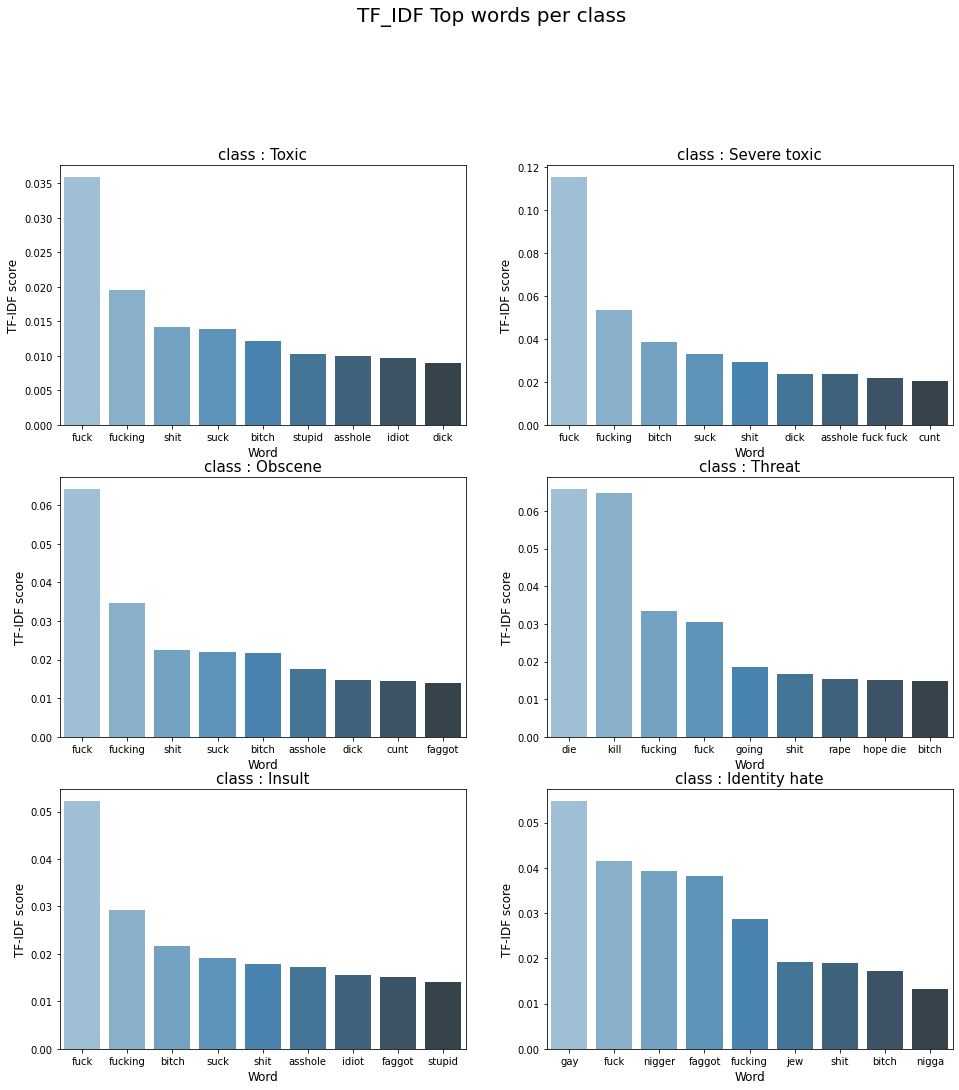

In [41]:
plt.figure(figsize=(16,22))
plt.suptitle("TF_IDF Top words per class",fontsize=20)
gridspec.GridSpec(4,2)
plt.subplot2grid((4,2),(0,0))
sns.barplot(tfidf_top_n_per_lass[0].feature.iloc[0:9],tfidf_top_n_per_lass[0].tfidf.iloc[0:9], palette=("Blues_d"))
plt.title("class : Toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(0,1))
sns.barplot(tfidf_top_n_per_lass[1].feature.iloc[0:9],tfidf_top_n_per_lass[1].tfidf.iloc[0:9], palette=("Blues_d"))
plt.title("class : Severe toxic",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(1,0))
sns.barplot(tfidf_top_n_per_lass[2].feature.iloc[0:9],tfidf_top_n_per_lass[2].tfidf.iloc[0:9], palette=("Blues_d"))
plt.title("class : Obscene",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(1,1))
sns.barplot(tfidf_top_n_per_lass[3].feature.iloc[0:9],tfidf_top_n_per_lass[3].tfidf.iloc[0:9], palette=("Blues_d"))
plt.title("class : Threat",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(2,0))
sns.barplot(tfidf_top_n_per_lass[4].feature.iloc[0:9],tfidf_top_n_per_lass[4].tfidf.iloc[0:9], palette=("Blues_d"))
plt.title("class : Insult",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)

plt.subplot2grid((4,2),(2,1))
sns.barplot(tfidf_top_n_per_lass[5].feature.iloc[0:9],tfidf_top_n_per_lass[5].tfidf.iloc[0:9], palette=("Blues_d"))
plt.title("class : Identity hate",fontsize=15)
plt.xlabel('Word', fontsize=12)
plt.ylabel('TF-IDF score', fontsize=12)


In [22]:
# using multinomial naive bayes (one of the two classic naive Bayes variants used in text classification)
# https://scikit-learn.org/stable/modules/naive_bayes.html
mnb = MultinomialNB()
svm = LinearSVC()

In [23]:
# performance
def cross_validation(classifier, X_train, y_train):
    result = []
    for label in test_labels:
        recall = cross_val_score(classifier, X_train, y_train[label], cv=10, scoring='recall')
        f1 = cross_val_score(classifier, X_train, y_train[label], cv=10, scoring='f1')
        result.append([label, recall.mean(), f1.mean()])
    return result

In [24]:
mnb_result = pd.DataFrame(cross_validation(mnb, X_train, train))
svm_result = pd.DataFrame(cross_validation(svm, X_train, train))

In [25]:
mnb_result.columns = ['Label', 'Recall', 'F1']
mnb_result

,Label,Recall,F1
0,toxic,0.254087,0.402578
1,severe_toxic,0.000625,0.001242
2,obscene,0.194106,0.323005
3,threat,0.000000,0.000000
4,insult,0.115273,0.204237
5,identity_hate,0.000000,0.000000


In [26]:
svm_result.columns = ['Label', 'Recall', 'F1']
svm_result

,Label,Recall,F1
0,toxic,0.677325,0.762801
1,severe_toxic,0.243251,0.326665
2,obscene,0.695468,0.776746
3,threat,0.221676,0.329135
4,insult,0.569377,0.659891
5,identity_hate,0.269772,0.384911


In [27]:
# prediction
def predict(classifier, X_train, y_train, X_test, y_test):
    result = []
    predict_df = pd.DataFrame()
    predict_df['id'] = test_y['id']
    
    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)
        predict_df[label] = predicted
        
        recall = recall_score(y_test[y_test[label] != -1][label], predicted[y_test[label] != -1],
                              average="weighted")
        f1 = f1_score(y_test[y_test[label] != -1][label], predicted[y_test[label] != -1],
                      average="weighted")
        result.append([label, recall.mean(), f1.mean()])
    return result

In [28]:
mnb_prediction = predict(mnb, X_train, train, X_test, test_y)
svm_prediction = predict(svm, X_train, train, X_test, test_y)

In [29]:
mnb_prediction = pd.DataFrame(mnb_prediction)
mnb_prediction.columns=['label', 'recall', 'f1']
mnb_prediction

,label,recall,f1
0,toxic,0.924912,0.903988
1,severe_toxic,0.994264,0.991404
2,obscene,0.951061,0.934066
3,threat,0.996702,0.995056
4,insult,0.950420,0.930401
5,identity_hate,0.988871,0.983338


In [30]:
svm_prediction = pd.DataFrame(svm_prediction)
svm_prediction.columns=['label', 'recall', 'f1']
svm_prediction

,label,recall,f1
0,toxic,0.923880,0.928069
1,severe_toxic,0.993091,0.992797
2,obscene,0.962253,0.962197
3,threat,0.996483,0.995987
4,insult,0.960064,0.958076
5,identity_hate,0.990090,0.988302


In [31]:
svm_prediction['Model'] = 'LinearSVM'
mnb_prediction['Model'] = 'MultinomialNB'

In [32]:
models = pd.concat([svm_prediction, mnb_prediction])
models

,label,recall,f1,Model
0,toxic,0.923880,0.928069,LinearSVM
1,severe_toxic,0.993091,0.992797,LinearSVM
2,obscene,0.962253,0.962197,LinearSVM
3,threat,0.996483,0.995987,LinearSVM
4,insult,0.960064,0.958076,LinearSVM
5,identity_hate,0.990090,0.988302,LinearSVM
0,toxic,0.924912,0.903988,MultinomialNB
1,severe_toxic,0.994264,0.991404,MultinomialNB
2,obscene,0.951061,0.934066,MultinomialNB
3,threat,0.996702,0.995056,MultinomialNB


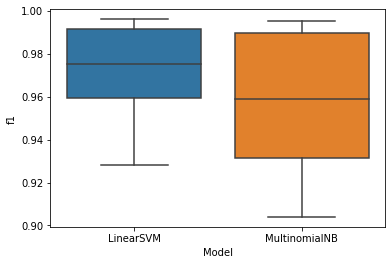

In [33]:
ax = sns.boxplot(x='Model',y='f1',data=models)

Linear Supoort Vector Machine is more accurate than Multinomial Naive-Bayes

In [54]:
train_clean = pd.read_csv('clean.csv')
subset=train_clean[train['toxic']==1]

In [55]:
subset

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_text
6,6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,cocksucker piss around work
12,12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,hey talk exclusive group wp taliban good destr...
16,16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,bye look come think comming back tosser
42,42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,gay antisemmitian archangel white tiger meow g...
43,43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,fuck filthy mother as dry
...,...,...,...,...,...,...,...,...,...,...
159494,159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1,previous conversation fucking shit eating lib...
159514,159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0,mischievious pubic hair
159541,159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0,absurd edits absurd edits great white shark to...
159546,159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0,hey listen ever delete edits ever annoyed wwe...


In [56]:
text=subset.comment_text.values
text

array(['COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK',
       'Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...',
       "Bye! \n\nDon't look, come or think of comming back! Tosser.", ...,
       "Your absurd edits \n\nYour absurd edits on great white shark was total vandalism and was very sexual. All you edit here is fucking bullshit like spam all over this useful encyclopedia so stop all your bullshit. The admins have you everywhere. The only choice for you is to stop this bullshit or else you'll be blocked permanently. User:Factual80man",
       '"\n\nHey listen don\'t you ever!!!! Delete my edits ever again I\'m annoyed because the WWE 2K15 a few of the roster have been confirmed and your stupid ass deletes what